In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [7]:
import scipy.stats
from sklearn.metrics import mean_squared_error

plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results/detection_per_mol/"


## Evaluation of classification


In [ ]:
filenames = {
    "all_feat": "detection_results_all_feat.csv",
    "fingerprints_feat": "detection_results_fingerprints_feat.csv",
    "mol_feat": "detection_results_mol_feat.csv",
    "random_feat": "detection_results_random_feat.csv",
    "no_feat": "detection_results_no_feat.csv",

}


In [ ]:
metric = "Spearman's R"

# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
models_results = pd.DataFrame()
model_metrics = pd.DataFrame(columns = ['regr_type', 'matrix', 'polarity', 'regressor', "Spearman's R",
                                                 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs'])
model_performance = pd.DataFrame()
counter = 0

for regr_type in filenames:
    result_filename = filenames[regr_type]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                          'Polarity': 'polarity'})


    for (matrix, polarity, regressor), rows in loc_models_results.groupby(['matrix', 'polarity', 'regressor']):
        # remove zero intensity molecules if needed (optional)
        rows = rows[rows['observed_value']!=0]

        spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
        pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
        mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
        mse_std = mse / rows['observed_value'].std()
        model_metrics.loc[counter] = [regr_type, matrix, polarity, regressor, spearman[0], spearman[1],
                                           pearson[0], pearson[1], mse, mse_std,
                                           rows[rows['observed_value']!=0].shape[0]]
        counter += 1

    loc_models_results["regr_type"] = regr_type
    models_results = pd.concat([models_results, loc_models_results])

    # FInd best model across matrices:
    loc_model_performance = pd.DataFrame()
    for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
        rows["difference"] = rows[metric] - rows[metric].max()
        loc_model_performance = pd.concat([loc_model_performance, rows[["regressor", "difference"]]])

    loc_model_performance = loc_model_performance.groupby(["regressor"]).sum()
    loc_model_performance["regr_type"] = regr_type
    model_performance = pd.concat([model_performance, loc_model_performance])



In [30]:
# result_filename = "detection_results_all_feat.csv"
# result_filename = "detection_results_fingerprints_feat.csv"
result_filename = "detection_results_mol_feat.csv"
# result_filename = "detection_results_one_random_mol_feat.csv"

detection_results = pd.read_csv(results_dir / result_filename, index_col = 0)
detection_results = detection_results.rename(columns={'Matrix short': 'matrix',
                                                      'Polarity': 'polarity'})
detection_results

,observed_value,prediction,classifier,name_short,matrix,polarity,fold
0,1,0,Logistic_reg,2-Oxoglutaric acid,9AA,negative,0
1,1,1,Logistic_reg,3-Hydroxyanthranilic acid,9AA,negative,0
2,0,1,Logistic_reg,3-Hydroxymethylglutaric acid,9AA,negative,0
3,1,1,Logistic_reg,3-Phosphoglyceric acid,9AA,negative,0
4,1,1,Logistic_reg,"4,5-Dihydroorotic acid",9AA,negative,0
...,...,...,...,...,...,...,...
123,1,0,GaussianProcess,Xanthine,pNA,positive,9
124,1,0,GaussianProcess,alpha-tocopherol,pNA,positive,9
125,1,0,GaussianProcess,cis-Aconitic acid,pNA,positive,9
126,1,1,GaussianProcess,gamma-Aminobutyric acid,pNA,positive,9


### Add baseline classifier
Randomly predict detected/not-detected, based on the detected probability for each matrix/polarity:


In [31]:
baseline_results = detection_results.drop(columns=["classifier", "prediction", "fold"]).drop_duplicates().reset_index(drop=True)
baseline_results["prediction"] = 0
baseline_results["fold"] = 0
baseline_results["classifier"] = "random_guess"

for (matrix, polarity), rows in baseline_results.groupby(['matrix', 'polarity']):
    detected_prob = float(rows["observed_value"].sum()) / len(rows)
    prediction = (np.random.random(size=len(rows)) < detected_prob).astype('int')
    baseline_results.loc[rows.index.to_list(), "prediction"] = prediction

detection_results = pd.concat([detection_results, baseline_results])



In [32]:
baseline_results

,observed_value,name_short,matrix,polarity,prediction,fold,classifier
0,1,2-Oxoglutaric acid,9AA,negative,1,0,random_guess
1,1,3-Hydroxyanthranilic acid,9AA,negative,1,0,random_guess
2,0,3-Hydroxymethylglutaric acid,9AA,negative,1,0,random_guess
3,1,3-Phosphoglyceric acid,9AA,negative,1,0,random_guess
4,1,"4,5-Dihydroorotic acid",9AA,negative,1,0,random_guess
...,...,...,...,...,...,...,...
3375,1,Xanthine,pNA,positive,1,0,random_guess
3376,1,alpha-tocopherol,pNA,positive,1,0,random_guess
3377,1,cis-Aconitic acid,pNA,positive,1,0,random_guess
3378,1,gamma-Aminobutyric acid,pNA,positive,1,0,random_guess


### Compute metrics

In [33]:
from sklearn.metrics import classification_report

score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                                            'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']

detection_metrics = pd.DataFrame(columns = ['matrix', 'polarity', 'classifier'] + score_cols)

counter = 0
for (matrix, polarity, classifier), rows in detection_results.groupby(['matrix', 'polarity', 'classifier']):
    clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
    if rows.observed_value.max() == 0:
        print("no detection!")
    detection_metrics.loc[counter] = [matrix, polarity, classifier,
                                      clf_report['0']['precision'], clf_report['0']['recall'],
                                      clf_report['0']['f1-score'], clf_report['0']['support'],
                                      clf_report['1']['precision'], clf_report['1']['recall'],
                                      clf_report['1']['f1-score'], clf_report['1']['support'],
                                      clf_report['macro avg']['f1-score']
                                      ]
    counter += 1


In [34]:
best_det_f1 = detection_metrics.loc[detection_metrics.groupby(['matrix', 'polarity'])["det_f1"].idxmax()].sort_values("macro_avg_f1_score", ascending=False)

best_det_f1[["matrix", "polarity",
             "classifier",
             # "not_det_f1",
             # "det_f1",
             "macro_avg_f1_score",
             "not_detected",
             "detected"
             ]]
# best_det_f1[["matrix", "polarity",  "det_f1", "classifier"]]
# best_det_f1["det_f1"].mean()
# best_det_f1

,matrix,polarity,classifier,macro_avg_f1_score,not_detected,detected
103,DHAP,positive,MLP,0.831193,72,97
109,DHB,negative,GaussianProcess,0.827453,113,56
21,CHCA,negative,Logistic_reg,0.822851,110,59
176,pNA,positive,RandomForest,0.803230,57,112
67,ClCCA,positive,MLP,0.802940,36,133
58,ClCCA,negative,MLP,0.785805,136,33
49,CMBT,positive,MLP,0.780609,62,107
130,NEDC,negative,MLP,0.759297,136,33
139,NEDC,positive,MLP,0.739314,130,39
151,NOR,negative,SVC_rbf,0.734124,59,110


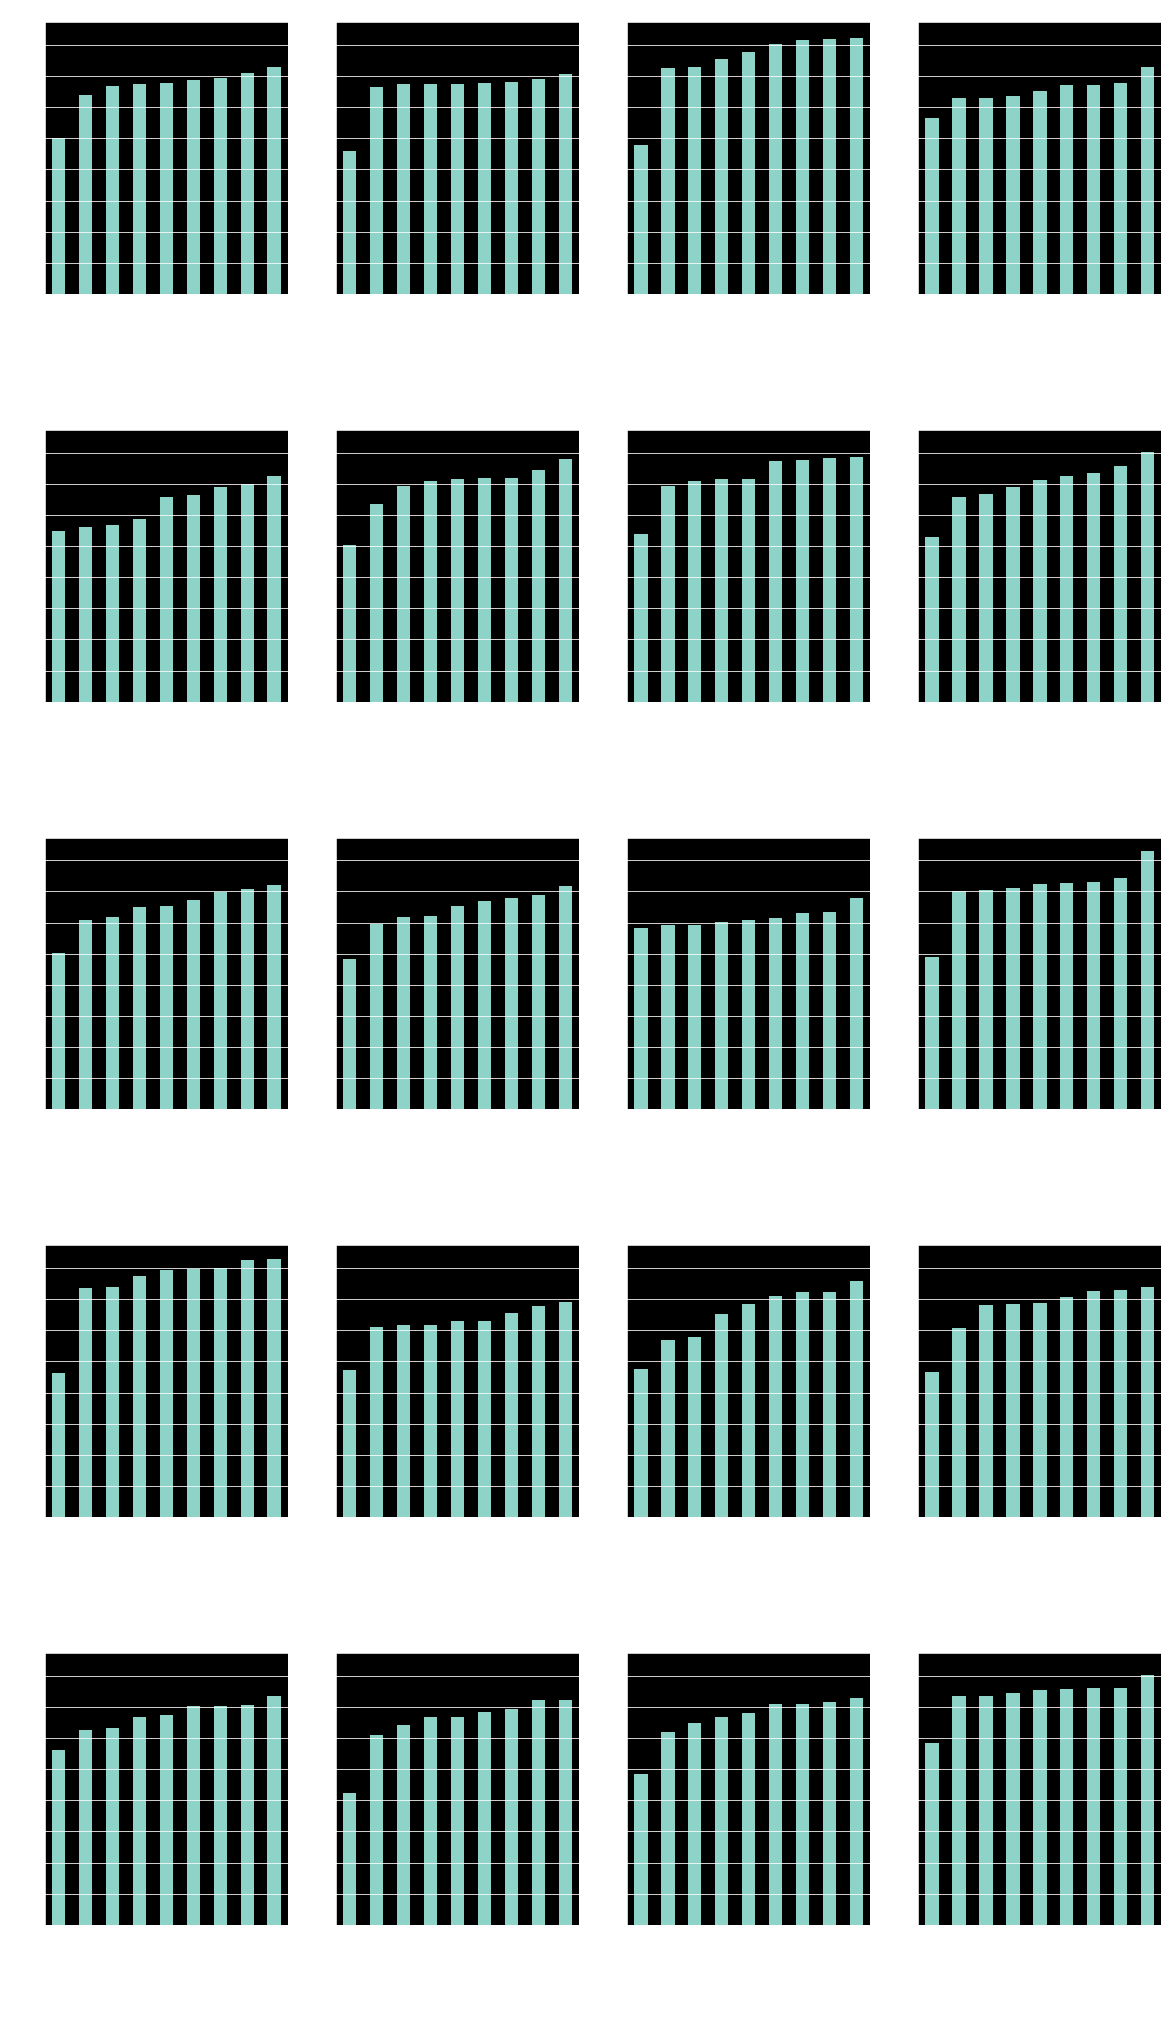

In [35]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "macro_avg_f1_score"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in detection_metrics.groupby(['matrix', 'polarity']):
    rows = rows.set_index('classifier', drop = True).sort_values( by = metric)
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    i+=1

plt.subplots_adjust(hspace=0.5)

plt.show()

plots_f1_score = plots_dir / "macro_avg_f1_score"
plots_f1_score.mkdir(exist_ok=True)
fig.savefig(plots_f1_score / result_filename.replace(".csv", ".pdf"))

### Find best model according to avg-f1

In [36]:
# FInd best model across matrices:
metric = "macro_avg_f1_score"
classifier_performance = pd.DataFrame()

for (matrix, polarity), rows in detection_metrics.groupby(['matrix', 'polarity']):
    rows["difference"] = rows[metric] - rows[metric].max()
    classifier_performance = pd.concat([classifier_performance, rows[["classifier", "difference"]]])

classifier_performance = classifier_performance.groupby(["classifier"]).sum()
classifier_performance.sort_values("difference", ascending=False)


,difference
classifier,
MLP,-0.244501
RandomForest,-0.805539
SVC_rbf,-0.984279
SVC_poly,-1.208503
DecisionTree,-1.345875
Logistic_reg,-1.358933
GaussianProcess,-1.495892
KNeighbors,-1.633759
random_guess,-4.926287


### Std of scores over folds:

In [62]:
from sklearn.metrics import classification_report

detection_metrics_over_fold = pd.DataFrame(columns = ['matrix', 'polarity', 'classifier', 'fold'] + score_cols)

counter = 0
for (matrix, polarity, classifier, fold), rows in detection_results.groupby(['matrix', 'polarity', 'classifier', 'fold']):
    clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
    if rows.observed_value.max() == 0:
        print("no detection! Aborting")
        break
    detection_metrics_over_fold.loc[counter] = [matrix, polarity, classifier, fold,
                                      clf_report['0']['precision'], clf_report['0']['recall'],
                                      clf_report['0']['f1-score'], clf_report['0']['support'],
                                      clf_report['1']['precision'], clf_report['1']['recall'],
                                      clf_report['1']['f1-score'], clf_report['1']['support'],
                                      clf_report['macro avg']['f1-score']
                                      ]
    counter += 1

# Now compute std over folds:
detection_metrics_over_fold = detection_metrics_over_fold.groupby(['matrix', 'polarity', 'classifier'], as_index=False)[score_cols].std()
detection_metrics_over_fold[detection_metrics_over_fold.classifier == "SVC_poly"]



,matrix,polarity,classifier,not_det_precision,not_det_recall,not_det_f1,not_detected,det_precision,det_recall,det_f1,detected,macro_avg_f1_score
6,9AA,negative,SVC_poly,0.292568,0.193218,0.215501,0.000000,0.093137,0.176445,0.129412,0.316228,0.167971
15,9AA,positive,SVC_poly,0.044629,0.086433,0.039127,0.632456,0.187651,0.165589,0.143025,0.483046,0.083710
24,CHCA,negative,SVC_poly,0.078228,0.111752,0.074880,0.000000,0.146348,0.159048,0.122153,0.316228,0.095550
33,CHCA,positive,SVC_poly,0.447989,0.331476,0.343549,0.527046,0.049497,0.116573,0.078031,0.516398,0.198229
42,CMBT,negative,SVC_poly,0.058518,0.098238,0.058917,0.316228,0.355833,0.306816,0.242320,0.421637,0.143365
51,CMBT,positive,SVC_poly,0.109360,0.217191,0.137179,0.632456,0.114436,0.092912,0.071468,0.483046,0.097111
60,ClCCA,negative,SVC_poly,0.061634,0.067416,0.043622,0.516398,0.247512,0.242797,0.193052,0.483046,0.116562
69,ClCCA,positive,SVC_poly,0.313626,0.281777,0.207832,0.516398,0.082665,0.165530,0.107857,0.483046,0.149757
78,DAN,negative,SVC_poly,0.174518,0.272732,0.210339,0.000000,0.135719,0.121952,0.110115,0.316228,0.153288
87,DAN,positive,SVC_poly,0.182131,0.219427,0.179688,0.516398,0.126492,0.224766,0.174674,0.527046,0.153467
